<a href="https://colab.research.google.com/github/jinisaweaklearner/DS-ML-Paper-Note-Code/blob/master/src/GradientBoostingDecisionTree(GBDT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Import Packages



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_text
from sklearn.tree import _tree

# Load Data

In [ ]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)

# Modelling

In [ ]:
lr = 0.3
n_trees = 3

In [ ]:
model = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=n_trees,
    learning_rate=lr,
    random_state = 42
)
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Interpretation step by step

In [ ]:
# get decision rules by model
def get_decision_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    # print("def tree({}):".format(", ".join(feature_names)))

    decision_rules = []
    def recurse(node, depth):
        indent = "  " * depth
        # print(tree_.feature[node])
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)

            decision_rules.append([name, threshold])
        #else:
            # print(depth)
            # print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    print('decision rules:', decision_rules[::-1])
    return decision_rules[::-1]

# get the particular 1st,2nd,3rd trees 
def get_tree(model,tree_index):
    return model.estimators_[tree_index][0]

In [ ]:
# get the relevant nodes for each observations 
def get_nodes_by_resid(d_rule,df_record,tree_number, prediction):
    nodes_for_resid = []
    resid = []
    
    for idx, row in X.iterrows():
        ground_truth = y[idx]
        pred = prediction[idx]
        residual = ground_truth - pred
        resid.append(residual)

        # hardcode the tree structure (depth=2)
        if row[d_rule[0][0]] <= d_rule[0][1]:
            if row[d_rule[2][0]] <= d_rule[2][1]:
                nodes_for_resid.append('a')
            else:
                nodes_for_resid.append('b')
        else:
            if row[d_rule[1][0]] <= d_rule[1][1]:
                nodes_for_resid.append('c')
            else:
                nodes_for_resid.append('d')
        
    return nodes_for_resid, resid

In [ ]:
def main(model, n_tree):
    for tree_number in range(n_tree):
        print('number of tree:',tree_number)

        # get single decision tree
        tree = get_tree(model,tree_number)
        # get decision rules
        d_rule = get_decision_rules(tree, boston['feature_names'])
        
        # initial values (avg) for the 1st tree
        if tree_number == 0:
            df_record = pd.DataFrame({'ground_truth':y})
            df_record['pred_0'] = [y.mean()]*len(X)

        # get the nodes of each observation
        prediction = df_record[f'pred_{tree_number}'].tolist()
        nodes_for_resid, resid = get_nodes_by_resid(d_rule,df_record,tree_number, prediction)
        
        # calculation and updating the residual
        df_record[f'node_{tree_number}'] = nodes_for_resid
        df_record[f'residual_{tree_number}'] = resid

        # get the avg residual of each node
        df_resid_nodes_stats = df_record.groupby(f'node_{tree_number}',as_index=False)[[f'residual_{tree_number}']].mean()
        df_resid_nodes_stats.rename(columns={f'residual_{tree_number}':f'residual_avg_{tree_number}'},inplace=True)
        df_record = pd.merge(df_record, df_resid_nodes_stats,on = f'node_{tree_number}',how='left')

        # get the updated predictions by using avg residual
        # prediction(n+1) = prediction(n) + lr * avg_residual_from_its_related_node
        df_record[f'pred_{tree_number+1}'] = df_record[f'pred_{tree_number}'] + df_record[f'residual_avg_{tree_number}']*model.learning_rate
        print('\n')
    return df_record

In [ ]:
df_records = main(model, model.n_estimators)

number of tree: 0
  if RM <= 6.940999984741211:
    if LSTAT <= 14.400000095367432:
    else:  # if LSTAT > 14.400000095367432
  else:  # if RM > 6.940999984741211
    if RM <= 7.437000036239624:
    else:  # if RM > 7.437000036239624
decision rules: [['RM', 6.940999984741211], ['RM', 7.437000036239624], ['LSTAT', 14.400000095367432]]


number of tree: 1
  if LSTAT <= 9.630000114440918:
    if LSTAT <= 4.650000095367432:
    else:  # if LSTAT > 4.650000095367432
  else:  # if LSTAT > 9.630000114440918
    if CRIM <= 5.848029851913452:
    else:  # if CRIM > 5.848029851913452
decision rules: [['LSTAT', 9.630000114440918], ['CRIM', 5.848029851913452], ['LSTAT', 4.650000095367432]]


number of tree: 2
  if RM <= 6.837500095367432:
    if LSTAT <= 19.229999542236328:
    else:  # if LSTAT > 19.229999542236328
  else:  # if RM > 6.837500095367432
    if NOX <= 0.6590000092983246:
    else:  # if NOX > 0.6590000092983246
decision rules: [['RM', 6.837500095367432], ['NOX', 0.6590000092983246]

In [ ]:
df_records.head()

,ground_truth,pred_0,node_0,residual_0,residual_avg_0,pred_1,node_1,residual_1,residual_avg_1,pred_2,node_2,residual_2,residual_avg_2,pred_3
0,24.0,22.532806,a,1.467194,0.816998,22.777906,b,1.222094,3.214128,23.742144,a,0.257856,-0.503113,23.591210
1,21.6,22.532806,a,-0.932806,0.816998,22.777906,b,-1.177906,3.214128,23.742144,a,-2.142144,-0.503113,23.591210
2,34.7,22.532806,c,12.167194,9.580237,25.406877,a,9.293123,13.308074,29.399300,c,5.300700,8.446460,31.933238
3,33.4,22.532806,c,10.867194,9.580237,25.406877,a,7.993123,13.308074,29.399300,c,4.000700,8.446460,31.933238
4,36.2,22.532806,c,13.667194,9.580237,25.406877,b,10.793123,3.214128,26.371116,c,9.828884,8.446460,28.905054


In [ ]:
df_records.filter(regex='pred').head()

,pred_0,pred_1,pred_2,pred_3
0,22.532806,22.777906,23.742144,23.591210
1,22.532806,22.777906,23.742144,23.591210
2,22.532806,25.406877,29.399300,31.933238
3,22.532806,25.406877,29.399300,31.933238
4,22.532806,25.406877,26.371116,28.905054


In [ ]:
# cross check the predictions of iteration
print('ground truth ', y[:5].tolist())
for i,pred in enumerate(model.staged_predict(X)):
  print('round:',i+1)
  print('pred         ', pred[:5])
  print('\n')

learning rate: 0.3 

ground truth  [24.0, 21.6, 34.7, 33.4, 36.2]
round: 1
pred          [22.7779056  22.7779056  25.40687747 25.40687747 25.40687747]


round: 2
pred          [23.74214414 23.74214414 29.3992997  29.3992997  26.37111601]


round: 3
pred          [23.59121031 23.59121031 31.93323755 31.93323755 28.90505386]




# Visualize trees

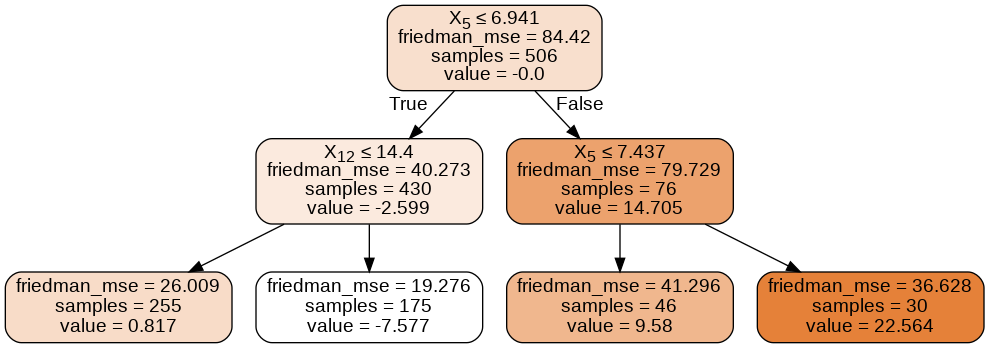

In [ ]:
sub_tree = model.estimators_[0, 0]

dot_data = export_graphviz(
    sub_tree,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=True,
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())